<a href="https://colab.research.google.com/github/ulyssesMonte/Redes-Convolucionais-de-grafos-para-an-lise-de-fMRI/blob/main/gnns_in_neuroscience_graph_convolutional_networks_for_fmri_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNNs na neurociência: redes convolucionais de grafos para análise de  ressonância magnética funcional

Por Sidney Hough, Julian Quevedo, e Pino Cholsaipant como parte do projeto de curso CS224W de Stanford. Link para o Artigo médio correspondente com explicações [aqui](https://medium.com/stanford-cs224w/gnns-in-neuroscience-graph-convolutional-networks-for-fmri-analysis-8a2e933bd802).

![](https://i.imgur.com/FYaEgKW.jpg)

Todas as instalações e importações que precisaremos.


In [ ]:
%%capture

#!pip install nilearn
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

In [ ]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

from nilearn import datasets
from nilearn import plotting
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import from_networkx

from torch.serialization import add_safe_globals
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr, GlobalStorage
add_safe_globals([GlobalStorage])
add_safe_globals([DataTensorAttr])



import networkx as nx
# from networkx.convert_matrix import from_numpy_matrix
from networkx import from_numpy_array

# **Preparação dos Dados**

Organização dos dados brutos dos cursos de Ressonancia magnetica funcional necessários para nossa atividade de aprendizado.

[Nilearn](https://nilearn.github.io/stable/index.html) É um ótimo exemplo de software de código aberto que possui utilidades e funções necessárias para cá!

![](https://i.imgur.com/vyyZA9t.png)

Criar os diretórios onde o nosso volume de dados vai estar salvo.

In [ ]:
dataset_path = 'dataset'
corr_matrices_dir = f'{dataset_path}/corr_matrices'
pcorr_matrices_dir = f'{dataset_path}/pcorr_matrices'
avg_pcorr_file = f'{dataset_path}/avg_pcorr.csv'
time_series_dir = f'{dataset_path}/time_series'
labels_file = f'{dataset_path}/labels.csv'
if not os.path.exists(corr_matrices_dir):
  os.makedirs(corr_matrices_dir)
if not os.path.exists(pcorr_matrices_dir):
  os.makedirs(pcorr_matrices_dir)
if not os.path.exists(time_series_dir):
  os.makedirs(time_series_dir)

Obter um atlas que divide o cérebro em regiões de interesse (ROIs) e obtenha os dados brutos de fMRI do OpenNeuro.

[Link](https://openneuro.org/datasets/ds000228/versions/1.1.0) para o dataset.

In [ ]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas.maps
atlas_labels = atlas.labels

data = datasets.fetch_development_fmri()

[fetch_atlas_msdl] Dataset found in /root/nilearn_data/msdl_atlas

[fetch_development_fmri] Dataset found in /root/nilearn_data/development_fmri

[fetch_development_fmri] Dataset found in /root/nilearn_data/development_fmri/development_fmri

[fetch_development_fmri] Dataset found in /root/nilearn_data/development_fmri/development_fmri

Extraia o sinal em cada ROI ao longo do tempo usando o atlas que acabamos de criar.

In [ ]:
# standardize=True means signals in time series signals are shifted to zero mean and scaled to unit variance
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, memory='nilearn_cache')

time_series = [0] * len(data.func)
labels = [0] * len(data.func)


for i in range(len(data.func)):
    sub_id = data.phenotypic['participant_id'].iloc[i]
    sub_num = int(sub_id.replace('sub-pixar', '')) - 1

    ts = masker.fit_transform(data.func[i], confounds=data.confounds[i])
    time_series[sub_num] = ts
    labels[sub_num] = data.phenotypic['Child_Adult'].iloc[i]


# Save time series
for i in range(len(time_series)):
  np.savetxt(f'{time_series_dir}/time_series_{i:04d}.csv', time_series[i], delimiter=',')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py:319: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  data_to_wrap = f(self, X, *args, **kwargs)


Calculando a matriz de correlação parcial para cada série temporal e calculando a média. Isso servirá de base para as arestas nos gráficos que criaremos posteriormente.



In [ ]:
corr_measure = ConnectivityMeasure(kind='correlation')
pcorr_measure = ConnectivityMeasure(kind='partial correlation')

corr_matrices = corr_measure.fit_transform(time_series)
pcorr_matrices = pcorr_measure.fit_transform(time_series)

# Get average partial correlation matrix across time series and save
avg_pcorr_matrix = np.mean(pcorr_matrices, axis=0)
np.savetxt(avg_pcorr_file, avg_pcorr_matrix, delimiter=',')

# Save correlation and partial correlation matrices
for i in range(0, len(corr_matrices)):
    np.savetxt(f'{corr_matrices_dir}/corr_{i:04d}.csv', corr_matrices[i], delimiter=',')
    np.savetxt(f'{pcorr_matrices_dir}/pcorr_{i:04d}.csv', pcorr_matrices[i], delimiter=',')

# Save labels
label_nums = [0 if label == 'child' else 1 for label in labels]
np.savetxt(labels_file, np.asarray(label_nums).astype(int), delimiter=',')

Vamos visualizar um connectome funcional!

In [ ]:
# Partial correlation matrix
plotting.plot_matrix(corr_matrices[0], labels=atlas_labels, colorbar=True, vmax=1, vmin=-0.8)
print("Média da conectividade (correlação):", np.mean(corr_matrices[0]))
print("Máximo da conectividade:", np.max(corr_matrices[0]))

# Connectome over brain schematic
coords = atlas.region_coords # Get center coordinates of each ROI
plotting.plot_connectome(corr_matrices[0], coords, edge_threshold="80%", colorbar=True)

coords = atlas.region_coords  # lista com coordenadas de cada ROI
plotting.plot_connectome(corr_matrices[0], coords, edge_threshold="80%", colorbar=True)


Defina uma classe personalizada para nosso conjunto de dados.

Para construir os gráficos, carregamos as matrizes de correlação parcial que calculamos anteriormente. As arestas são formadas entre as ROIs e seus correlatos diferentes de zero.

Em seguida, pegamos nossas matrizes de correlação e as usamos como recursos para nossos gráficos.

In [ ]:
class DevDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, neighbors=10):
        self.neighbors = neighbors
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        """ Converts raw data into GNN-readable format by constructing
        graphs out of connectivity matrices.

        """

        # Paths of connectivity matrices
        corr_path_list = sorted(os.listdir(corr_matrices_dir), key=lambda x: int(x[-8:-4]))
        pcorr_path_list = sorted(os.listdir(pcorr_matrices_dir), key=lambda x: int(x[-8:-4]))

        graphs = []
        labels = torch.from_numpy(np.loadtxt(labels_file, delimiter=','))
        for i in range(0, len(corr_path_list)):
            corr_matrix_path = os.path.join(corr_matrices_dir, corr_path_list[i])
            pcorr_matrix_path = os.path.join(pcorr_matrices_dir, pcorr_path_list[i])

            # Pushing partial correlation matrices through pipeline to get final Data object
            pcorr_matrix_np = np.loadtxt(pcorr_matrix_path, delimiter=',')

            index = np.abs(pcorr_matrix_np).argsort(axis=1)
            n_rois = pcorr_matrix_np.shape[0]

            # Take only the top k correlates to reduce number of edges
            for j in range(n_rois):
                for k in range(n_rois - self.neighbors):
                    pcorr_matrix_np[j, index[j, k]] = 0
                for k in range(n_rois - self.neighbors, n_rois):
                    pcorr_matrix_np[j, index[j, k]] = 1

            pcorr_matrix_nx = from_numpy_array(pcorr_matrix_np)
            pcorr_matrix_data = from_networkx(pcorr_matrix_nx)

            # Correlation matrix which will serve as our features
            corr_matrix_np = np.loadtxt(corr_matrix_path, delimiter=',')

            pcorr_matrix_data.x = torch.tensor(corr_matrix_np).float()
            pcorr_matrix_data.y = labels[i].type(torch.LongTensor)

            # Add to running list of all dataset items
            graphs.append(pcorr_matrix_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
dataset = DevDataset('dataset_pyg')
dataset = dataset.shuffle()

# Train/test split (80-20)
train_share = int(len(dataset) * 0.8)

train_dataset = dataset[:train_share]
test_dataset = dataset[train_share:]

# **Model definition**

Definir classe simplificada do modelo [cGCN](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7935029/).

No artigo sobre cGCN, os autores constroem uma sequência de gráficos para cada sujeito, cada um correspondendo a uma etapa diferente em sua série temporal. Utilizamos a matriz de correlação parcial para todos os sujeitos e selecionamos as k conexões mais influentes como arestas para cada ROI.
![](https://i.imgur.com/uDalqlP.png)
*Wang et al.*

In [ ]:
class GraphNetwork(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        # Initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels), ReLU())
        self.mlp2 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp3 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())

        # Initialize EdgeConv layers
        self.conv1 = EdgeConv(self.mlp1, aggr='max')
        self.conv2 = EdgeConv(self.mlp2, aggr='max')
        self.conv3 = EdgeConv(self.mlp3, aggr='max')

        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        """ Performs a forward pass on our simplified cGCN.

        Parameters:
        data (Data): Graph being passed into network.

        Returns:
        torch.Tensor (N x 2): Probability distribution over class labels.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        x = global_mean_pool(x, batch)
        x = self.linear(x)
        x = F.softmax(x, dim=1)

        return x

# Treinamento
Ultimos passos do treinamento para o nosso modelo.

In [ ]:
def train(model, loss_fn, device, data_loader, optimizer):
    """ Performs an epoch of model training.

    Parameters:
    model (nn.Module): Model to be trained.
    loss_fn (nn.Module): Loss function for training.
    device (torch.Device): Device used for training.
    data_loader (torch.utils.data.DataLoader): Data loader containing all batches.
    optimizer (torch.optim.Optimizer): Optimizer used to update model.

    Returns:
    float: Total loss for epoch.
    """
    model.train()
    loss = 0

    for batch in data_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch)

        loss = loss_fn(out, batch.y)

        loss.backward()
        optimizer.step()

    return loss.item()

def eval(model, device, loader):
    """ Calculate accuracy for all examples in a DataLoader.

    Parameters:
    model (nn.Module): Model to be evaluated.
    device (torch.Device): Device used for training.
    loader (torch.utils.data.DataLoader): DataLoader containing examples to test.
    """
    model.eval()
    cor = 0
    tot = 0

    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)

        y = batch.y
        cor += (pred == y).sum()
        tot += pred.shape[0]

    return cor / tot

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: -0.6591, Train: 80.65%, Test: 70.97%
Epoch: 02, Loss: -0.8935, Train: 85.48%, Test: 74.19%
Epoch: 03, Loss: -0.8691, Train: 80.65%, Test: 70.97%
Epoch: 04, Loss: -0.9688, Train: 80.65%, Test: 70.97%
Epoch: 05, Loss: -0.9637, Train: 85.48%, Test: 74.19%
Epoch: 06, Loss: -0.9651, Train: 99.19%, Test: 83.87%
Epoch: 07, Loss: -0.9975, Train: 100.00%, Test: 80.65%
Epoch: 08, Loss: -0.9992, Train: 99.19%, Test: 80.65%
Epoch: 09, Loss: -0.9974, Train: 98.39%, Test: 87.10%
Epoch: 10, Loss: -0.9100, Train: 99.19%, Test: 90.32%
Epoch: 11, Loss: -0.9974, Train: 99.19%, Test: 90.32%
Epoch: 12, Loss: -0.9618, Train: 98.39%, Test: 93.55%
Epoch: 13, Loss: -0.9720, Train: 98.39%, Test: 90.32%
Epoch: 14, Loss: -0.9995, Train: 100.00%, Test: 83.87%
Epoch: 15, Loss: -0.9823, Train: 99.19%, Test: 83.87%
Epoch: 16, Loss: -0.9608, Train: 100.00%, Test: 83.87%
Epoch: 17, Loss: -0.9997, Train: 100.00%, Test: 83.87%
Epoch: 18, Loss: -0.9999, Train: 100.00%, Test: 87.10%
Epoch: 19, Loss: -0.999

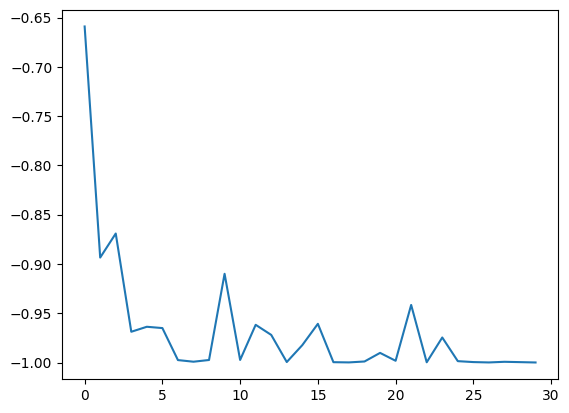

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphNetwork(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loss_fn = torch.nn.NLLLoss()
losses = []

for epoch in range(0, 30):
    loss = train(model, loss_fn, device, train_loader, optimizer)
    train_result = eval(model, device, train_loader)
    test_result = eval(model, device, test_loader)

    losses.append(loss)

    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_result:.2f}%, '
          f'Test: {100 * test_result:.2f}%')

plt.plot(losses)
plt.show()

# **Seção bônus: implementação completa do cGCN**

Embora a implementação completa do cGCN (com mais de um quadro de entrada) não tenha um bom desempenho em nossa tarefa, incluímos nossa implementação para referência.

***Construindo o conjunto de dados***
Para construir estes gráficos, carregamos a matriz de correlação parcial média que calculamos anteriormente. As arestas são formadas entre as ROIs e suas k conexões mais fortes. Usamos os sinais das séries temporais como recursos para nossos gráficos.

[ ]

In [ ]:
class CogFullDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, neighbors=10):
        self.neighbors = neighbors
        super().__init__(root, transform, pre_transform)

        # Solução 1: Usar weights_only=False (se você confia no arquivo)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

        # Alternativa - Solução 2: Usar safe_globals (mais seguro)
        # from torch.serialization import add_safe_globals
        # from torch_geometric.data.data import DataEdgeAttr
        # add_safe_globals([DataEdgeAttr])
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        graphs = []

        # Certifique-se de que estas variáveis estão definidas
        # avg_pcorr_file, labels_file, time_series_dir devem estar definidas
        avg_pcorr_matrix = np.loadtxt(avg_pcorr_file, dtype=float, delimiter=',')
        index = avg_pcorr_matrix.argsort(axis=1)
        n_rois = avg_pcorr_matrix.shape[0]

        # Take only the top k correlates for each ROI to reduce number of edges
        for i in range(n_rois):
            for j in range(n_rois - self.neighbors):
                avg_pcorr_matrix[i, index[i, j]] = 0
            for j in range(n_rois - self.neighbors, n_rois):
                avg_pcorr_matrix[i, index[i, j]] = 1

        labels = torch.from_numpy(np.loadtxt(labels_file, delimiter=','))

        # Assign features and labels to graphs using time series
        for i, path in enumerate(sorted(os.listdir(time_series_dir))):
            time_series_path = os.path.join(time_series_dir, path)
            ts = torch.from_numpy(np.loadtxt(time_series_path, dtype=float, delimiter=',')).T.float()

            # Construct graph object from partial correlation matrix
            # All training examples will share the same edges
            pcorr_matrix_nx = from_numpy_array(avg_pcorr_matrix)
            pcorr_matrix_data = from_networkx(pcorr_matrix_nx)

            pcorr_matrix_data.x = ts.type(torch.FloatTensor) # Time series signals are features for nodes
            pcorr_matrix_data.y = labels[i].type(torch.LongTensor)

            graphs.append(pcorr_matrix_data)

        data, slices = self.collate(graphs)

        # Salvar com weights_only=False também
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
dataset_full = CogFullDataset('dataset_full_pyg')
dataset_full = dataset_full.shuffle()

# Train/test split (80-20)
train_share_full = int(len(dataset_full) * 0.8)

train_dataset_full = dataset_full[:train_share]
test_dataset_full = dataset_full[train_share:]

Vemos que há 475 arestas no total em cada gráfico e 39 ROIs. (O motivo de haver menos de 39 * arestas vizinhas é que algumas ROIs compartilham os principais correlatos.)

In [ ]:
print(dataset[0])

Data(edge_index=[2, 437], weight=[437], x=[39, 39], y=[1], num_nodes=39)


### **Definição do model**

Usamos EdgeConv aqui em vez de GraphConv, como feito no cGCN. EdgeConv aprende uma MLP sobre recursos de aresta.

In [ ]:
class ConvLayers(torch.nn.Module):
    def __init__(self, hidden_channels, n_classes, n_rois, n_samples):
        super(ConvLayers, self).__init__()
        self.n_rois = n_rois
        self.n_samples = n_samples
        in_channels = 1

        # Initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * in_channels, hidden_channels), ReLU())
        self.mlp2 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp3 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp4 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp5 = Sequential(torch.nn.Linear(2 * 4 * hidden_channels, hidden_channels), ReLU())

        # Initialize EdgeConv layers
        self.conv1 = EdgeConv(self.mlp1, aggr='max')
        self.conv2 = EdgeConv(self.mlp2, aggr='max')
        self.conv3 = EdgeConv(self.mlp3, aggr='max')
        self.conv4 = EdgeConv(self.mlp4, aggr='max')
        self.conv5 = EdgeConv(self.mlp5, aggr='max')

        self.bn = BatchNorm1d(self.n_samples)

        # RNN to combine representations of nodes at each time frame
        self.rnn = GRU(input_size = hidden_channels, hidden_size = hidden_channels, num_layers=2, dropout=0.2, batch_first=True)
        self.linear = Linear(n_rois * hidden_channels, n_classes)


    def forward(self, data):
        X, edge_index = data.x, data.edge_index

        # T = time
        # N = batch size
        # V = ROIs
        # H = hidden channels

        X = X.unsqueeze(dim=2) # (N * V) x T x 1
        X = X.transpose(0, 1) # T x (N * V) x 1

        X_1 = self.conv1(X, edge_index)
        X_2 = self.conv2(X_1, edge_index)
        X_3 = self.conv3(X_2, edge_index)
        X_4 = self.conv4(X_3, edge_index) # T x (N * V) x H
        X_5 = self.conv5(torch.cat((X_1, X_2, X_3, X_4), dim=2), edge_index) # T x (N * V) x H

        # Temporal average pooling - ALTERNATIVE TO RNN
        # x = X_5.reshape((X_5.shape[0], int(X_5.shape[1] / self.n_rois), self.n_rois, X_5.shape[2]))
        # x = torch.flatten(x, 2, 3)
        # x = self.linear(x)
        # x = F.softmax(x, dim=2)
        # out = torch.mean(x, dim=0)

        # Learn an RNN
        x = X_5.transpose(0, 1) # (N * V) x T x H
        x = self.rnn(x)[0]
        x = F.relu(self.bn(x))
        x = x.transpose(0, 1)
        x = x.reshape((x.shape[0], int(x.shape[1] / self.n_rois), self.n_rois, x.shape[2]))
        x = torch.flatten(x, 2, 3)
        x = self.linear(x)
        x = F.softmax(x, dim=2)

        out = torch.mean(x, dim=0)

        return out

### **Treinamento**

In [ ]:
model_full = ConvLayers(20, 2, 39, 168).to(device)
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=0.00001)

train_loader_full = DataLoader(train_dataset_full, batch_size=32, shuffle=True)
test_loader_full = DataLoader(test_dataset_full, batch_size=32, shuffle=False)

loss_fn_full = torch.nn.CrossEntropyLoss()
losses_full = []

for epoch in range(50):
  loss = train(model_full, loss_fn_full, device, train_loader_full, optimizer_full)
  train_result = eval(model_full, device, train_loader_full)
  test_result = eval(model_full, device, test_loader_full)

  losses_full.append(loss)

  print(f'Epoch: {epoch + 1:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_result:.2f}%, '
        f'Test: {100 * test_result:.2f}%')

plt.plot(losses_full)
plt.show()

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 0.6429, Train: 80.65%, Test: 70.97%
Epoch: 02, Loss: 0.6390, Train: 80.65%, Test: 70.97%
Epoch: 03, Loss: 0.6559, Train: 80.65%, Test: 70.97%
Epoch: 04, Loss: 0.6300, Train: 80.65%, Test: 70.97%
Epoch: 05, Loss: 0.6271, Train: 80.65%, Test: 70.97%
Epoch: 06, Loss: 0.6142, Train: 80.65%, Test: 70.97%
Epoch: 07, Loss: 0.6379, Train: 80.65%, Test: 70.97%
Epoch: 08, Loss: 0.6056, Train: 80.65%, Test: 70.97%
Epoch: 09, Loss: 0.6022, Train: 80.65%, Test: 70.97%
Epoch: 10, Loss: 0.6303, Train: 80.65%, Test: 70.97%
Epoch: 11, Loss: 0.6158, Train: 80.65%, Test: 70.97%
Epoch: 12, Loss: 0.6008, Train: 80.65%, Test: 70.97%
Epoch: 13, Loss: 0.5613, Train: 80.65%, Test: 70.97%
Epoch: 14, Loss: 0.5948, Train: 80.65%, Test: 70.97%
Epoch: 15, Loss: 0.5785, Train: 80.65%, Test: 70.97%
Epoch: 16, Loss: 0.6147, Train: 80.65%, Test: 70.97%
Epoch: 17, Loss: 0.6141, Train: 80.65%, Test: 70.97%
Epoch: 18, Loss: 0.5967, Train: 80.65%, Test: 70.97%
Epoch: 19, Loss: 0.5942, Train: 80.65%, Test: 